# <font color='blue'>Table of contents</font>

- [LeNet5 Architecture](#lenet)
- [Display the Network](#display)
- [Get the MNIST Data](#get-data)
- [System Configuration](#sys-config)
- [Training Configuration](#train-config)
- [System Setup](#sys-setup)
- [Training](#training)
- [Validation](#validation)
- [Main function](#main)
- [Plot Loss](#plot-loss)
- [Plot Accuracy](#plot-acc)
- [Save the Model Parameters](#save-model)
- [Load the Model Parameters](#load-model)
- [Model Prediction](#predict)
- [Run Inference on Sample Images](#infer)
- [References](#refs)

# <font style="color:blue">Convolutional Neural Networks </font>

In this notebook, we will construct the LeNet architecture and, use the MNIST dataset to train it.


It was in 1998 that Yann LeCun, Leon Bottou, Yosuha Bengio and Patrick Haffner first proposed this neural network architecture for handwritten and machine-printed character recognition.

Follow this notebook to get familiar with the different layers involved in creating a CNN, and learn to use it oto create such a network. The training pipeline is similar to the MLP one we did last week.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [3]:
import os
import time

from typing import Iterable, Tuple
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

## <font style="color:green">1. LeNet5 Architecture</font><a name="lenet"></a>

This network has two convolutional layers and three fully connected layers.

The model architecture has been divided into 2 parts:



1. **`body`**: This implements the Convolutional part of the network, which consists of the `2` convolutional layers. Each convolutional layer is followed by a pooling layer. It also works as a feature extractor, in classical Machine Learning terms.
1. **`head`**: This implements the fully-connected part of the network. Consists of `3` fully-connected layers, with the last layer having the 10 output classes. It also works  as a classifier.


Finally, after creating the network, we also define the forward function which is executed when we pass an image through the network.

### <font style="color:green">Convolutional Layer Function Syntax </font>

```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```
Where,

- **`in_channels`**: number of input channels. For example, for colored image inputs, `in_channel` must be `3`. If `out_channels` of the first `conv2d` is `6` then `in_channels` of the second `conv2d` layer must be `6`.

- **`out_channel`:**  number of filters.

- **`kernel_size`:** `int` or `tuple of int`. If it is `int`,  height and width will be the same. If it is a `tuple of int`, the first element will be the height (number of rows) of filter, while second element denotes its  width (number of columns) of the filter.


- **`padding`:** padding can also be `int` or `tuple of int`. As in `kernel_size`, if it is `int` same padding will be done across the height and width.  The default is zero padding.

At this point, do not consider other  argumentsas of. To know more, click [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d).

**Note:** There is no activation after the last linear layer. So during inference, if we want probability as the output, we need to pass the model output through `softmax`.

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),

            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120),

            # ReLU activation
            nn.ReLU(inplace=True),

            # second fully connected layer
            # in_features = output of last linear layer = 120
            nn.Linear(in_features=120, out_features=84),

            # ReLU activation
            nn.ReLU(inplace=True),

            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

## <font style="color:green">2. Display the Network</font><a name="display"></a>

In [5]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## <font style="color:green">3. Get MNIST Data</font><a name="get-data"></a>

Load the train and test data, using the dataloader class in PyTorch. The dataloader gives an iterator that spits out batches of data, when asked. Also, transform the data as required, using the transforms.Compose function:

Load the train and test data, using the dataloader class in PyTorch. The dataloader gives an iterator that spits out batches of data, when asked. Also, transform the data as required, using the <a href="https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose" target="_blank">transforms.Compose</a>
function:

```python
train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
```

**Do the  following on the input data:**

1. Resize to `32 x 32` to match the  the input size to the model. For more details of` transforms.Resize`, <a href="https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize" target="_blank">click here</a>.

2. Rescale image tensor values between `0-1`. Divide each pixel by `255`. For  more details of `transforms.ToTensor`, <a href="https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor" target="_blank">click here</a>.

3. Normalize the data, by subtracting mean and dividing by variance. This is also known as standardization. For more details of `transforms.Normalize`, <a href="https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize" target="_blank">click here</a>.


In [6]:
def get_data(batch_size, data_root='data', num_workers=1):

    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])

    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

## <font style="color:green">4. System Configuration</font><a name="sys-config"></a>

It is best to have the configuration parameters in separate files. Here, we use a single notebook, therefore let’s start by creating a class for it, and later see how to **structure the project** such that separate files can be maintained.


In **`SystemConfiguration`** class, we defined a few attributes to get reproducible results, every time we run the notebook. Generally, this is a good practice. 

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## <font style="color:green">5. Training Configuration</font><a name="train-config"></a>

In **`TrainingConfiguration`**  class,  we have specified the configuration parameters of the training process. We are already familiar with these configurations. This is also a good practice since you don't need to change the network architecture so often as you change the training parameters. So, keeping them in a separate file/class helps you keep your code modular and clean.

In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.



## <font style="color:green">6. System Setup</font><a name="sys-setup"></a>

Let us define a function, **`setup_system`** that will check the `SystemConfiguration` attributes and update the system settings accordingly. For example, it sets the device to GPU/CPU depending on GPU availability on your system.

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">7. Training</font><a name="training"></a>

You are familiar with the training pipeline used in PyTorch. Follow the steps given below:

1. Send the data to the required device ( CPU/GPU ).
1. Make a forward pass using the forward method.
1. Find the loss using the Cross_Entropy function.
1. Find the gradients using the backward function.
1. Update the weights using the optimizer.
1. Find the accuracy of the model.

Repeat the above for the specified number of epochs.

In [10]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> Tuple[float, float]:

    # change model in training mode
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)

        # cross entropy loss
        loss = F.cross_entropy(output, target)

        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # get probability score using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

## <font style="color:green">8. Validation</font><a name="validation"></a>

After every few epochs, you must do **`validation`** with the trained model and `test_loader` in order to get validation loss and accuracy.

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0

    # turn off gradient-computation
    with torch.no_grad():

        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)

            target = target.to(train_config.device)

            output = model(data)
            # add loss for each mini batch
            test_loss += F.cross_entropy(output, target).item()

            # get probability score using softmax
            prob = F.softmax(output, dim=1)

            # get the index of the max probability
            pred = prob.data.max(dim=1)[1]

            # add correct prediction count
            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        # average over number of mini-batches
        test_loss = test_loss / len(test_loader)

        # average over number of dataset
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

## <font style="color:green">9. Main</font><a name="main"></a>


In this section of code, we use the configuration parameters defined above and start training.

1. Set up system parameters like CPU/GPU, number of threads etc.
1. Load the data using dataloaders.
1. Create an instance of the LeNet model.
1. Specify optimizer to use.
1. Set up variables to track loss and accuracy and start training.

In [12]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):

    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )

    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = LeNet5()

    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            if current_loss < best_loss:
                best_loss = current_loss

    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [13]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Train Epoch: 0 [1600/60000] Loss: 2.304386 Acc: 0.0625
Train Epoch: 0 [3200/60000] Loss: 2.020136 Acc: 0.3750
Train Epoch: 0 [4800/60000] Loss: 0.966735 Acc: 0.6250
Train Epoch: 0 [6400/60000] Loss: 1.003069 Acc: 0.5625
Train Epoch: 0 [8000/60000] Loss: 1.318518 Acc: 0.6875
Train Epoch: 0 [9600/60000] Loss: 0.402901 Acc: 0.8125
Train Epoch: 0 [11200/60000] Loss: 0.196657 Acc: 1.0000
Train Epoch: 0 [12800/60000] Loss: 0.104711 Acc: 1.0000
Train Epoch: 0 [14400/60000] Loss: 0.796018 Acc: 0.7500
Train Epoch: 0 [16000/60000] Loss: 0.345859 Acc: 0.8750
Train Epoch: 0 [17600/60000] Loss: 0.335726 Acc: 0.9375
Train Epoch: 0 [19200/60000] Loss: 0.063619 Acc: 1.0000
Train Epoch: 0 [20800/60000] Loss: 0.300627 Acc: 0.8750
Train Epoch: 0 [22400/60000] Loss: 0.705214 Acc: 0.8750
Train Epoch: 0 [24000/60000] Loss: 0.116482 Acc: 0.9375
Train Epoch: 0 [25600/60000] Loss: 0.180978 Acc: 0.9375
Train Epoch: 0 [27200/60000] Loss: 0.156765 Acc: 0.8750
Train Epoch: 0 [28800/60000] Loss: 0.270684 Acc: 0.937

## <font style="color:green">10. Plot Loss</font><a name="plot-loss"></a>

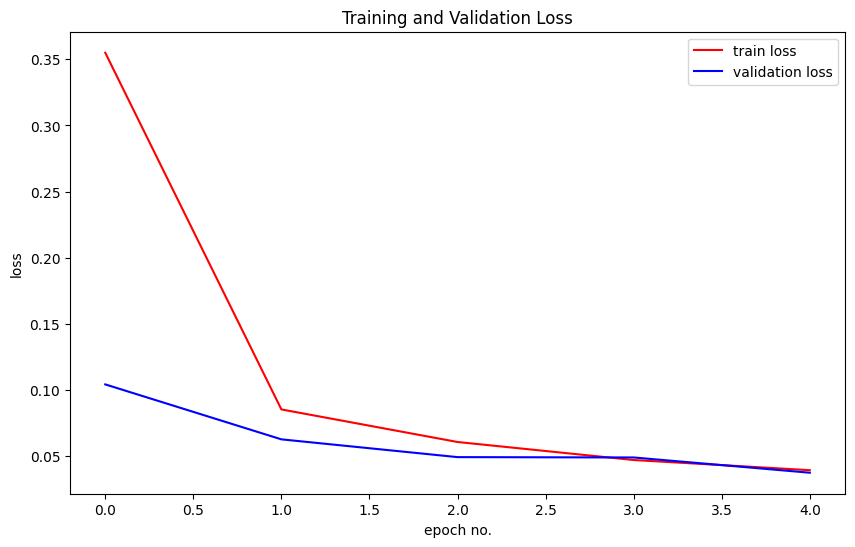

In [14]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font style="color:green">11. Plot Accuracy</font><a name="plot-acc"></a>

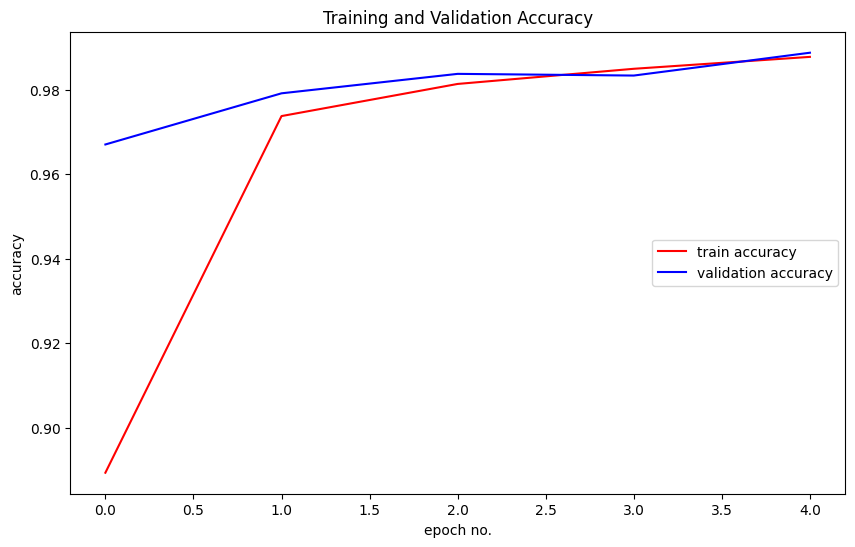

In [15]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

## <font style="color:green">12. Save the Model Parameters</font><a name="save-model"></a>

After training the model, you need to save it.  Later, use it for inference or to resume training from where you paused it.  ( Eg:, When you use free services like Google Colab etc.)

While saving or loading the model, the most important concept to understand is `state_dict`. The model, as you know, consists of parameters learned during training. These can now be accessed using the `model.parameters()` method. Also, there are some optimizer parameters.  These carry information on hyperparameters like learning rate, optimizer used etc.


All the above information is stored in the form of `state_dict`s. There are separate state_dicts for model parameters (`model.state_dict()`) and optimizer (`optimizer.state_dict()`). 


So, if you want to save the model for inference, save the state_dict of the model only. However, if you want to resume training from some checkpoint, you need to save the optimizer's `state_dict` as well (more discussion on checkpoints later).


Save the model using the code below:

**Note:** It's a good practice to save the `CPU` compatible model. So before saving, send the model to the `CPU` using `model.to('cpu')`.

In [16]:
models = 'models'
if not os.path.exists(models):
    os.makedirs(models)

model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

# make sure you transfer the model to cpu.
model.to('cpu')

# save the state_dict
torch.save(model.state_dict(), model_path)

## <font style="color:green">13. Load the Model Parameters </font><a name="load-model"></a>
After saving the model's state_dict, you can load the parameters into the model using similar functions. 

1. Create an instance of the model class.

1. Load the parameters by using `torch.load(model_path)`.

1. Load the parameters inside the model using `model.load_state_dict()`.

In [17]:
# initialize the model
lenet5_mnist = LeNet5()

# loading the model and getting model parameters by using load_state_dict
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## <font style="color:green">14. Model Prediction</font><a name="predict"></a>

Use the trained model to perform inference on new data. Just do a forward pass through the network, and use  softmax on the output. This will give us a probability score of the prediction.


Finally, we find the argmax of the output. It tells us which class  the prediction belongs to.


In [18]:
def prediction(model, train_config, batch_input):

    # turn off gradient-computation
    with torch.no_grad():

        # send model to cpu/cuda according to your system configuration
        model.to(train_config.device)

        # it is important to do model.eval() before prediction
        model.eval()

        data = batch_input.to(train_config.device)

        output = model(data)

        # get probability score using softmax
        prob = F.softmax(output, dim=1)

        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]

        # get the index of the max probability
        pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:green">15. Run Inference on Sample Images </font><a name="infer"></a>

For prediction, we need to transform the data like we did for training.

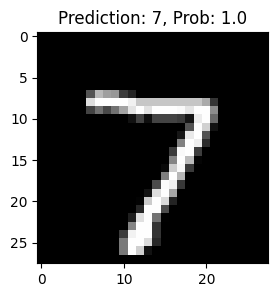

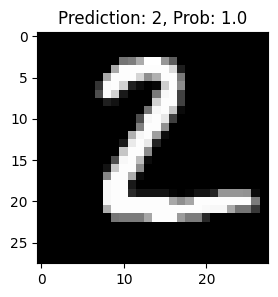

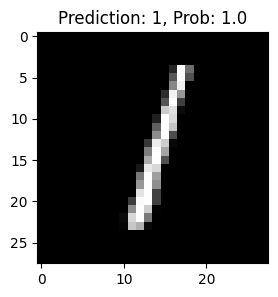

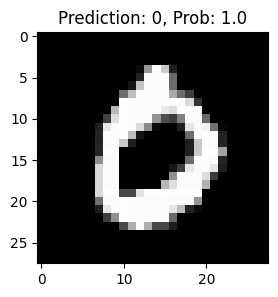

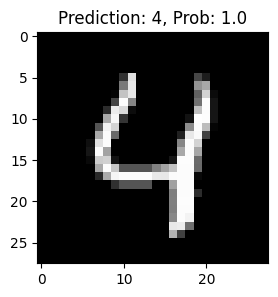

In [19]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True,
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break


plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break

# <font style="color:blue">References</font><a name="refs"></a>

1. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
1. https://pytorch.org/tutorials/beginner/saving_loading_models.html